In [ ]:

import pandas as pd
import glob
import re

%pip install yfinance
import yfinance as yf
import numpy as np
%pip install TA-Lib
import talib  # Library for technical indicators

In [70]:
#A note for the price, file date is the day after all the tweets inside. So the label should be created, as such that it reflex:
#file date over previous day change. 
#What index should I use/should I use my own file (maybe not, too big/detailed for daily ticker). Let's go with Yahoofinance.
#now, let's create the price change label, return diff, log return diff, and binary label 
start_date ='2019-12-28'
end_date = '2025-03-19'
price = yf.download("NVDA", start=start_date, end=end_date)
price_2 = price[["Close"]].copy()  # Keeps it as a DataFrame

# Calculate log returns and regular returns
price['change'] = price['Close'] / price['Close'].shift(1) - 1
price['log_change'] = np.log(price['Close']) - np.log(price['Close'].shift(1))

# Calculate RSI using a manual function (no talib dependency)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # First calculations
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    # Calculate RS
    rs = avg_gain / avg_loss
    
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI to the dataframe
price['rsi'] = calculate_rsi(price['Close'])

# Calculate volatility (20-day rolling standard deviation of log returns, annualized)
price['volatility'] = price['log_change'].rolling(window=20).std() * np.sqrt(252)

# Create binary label for price change (True if positive)
price['change_label'] = price['change'] > 0

# Reset index to make Date a column
price = price.reset_index()

# Create a date string column (YYYY-MM-DD format)
# price['date'] = price['Date'].apply(lambda x: str(x)[:10])



[*********************100%***********************]  1 of 1 completed


In [72]:
price.head()
price.columns

MultiIndex([(        'Date',     ''),
            (       'Close', 'NVDA'),
            (        'High', 'NVDA'),
            (         'Low', 'NVDA'),
            (        'Open', 'NVDA'),
            (      'Volume', 'NVDA'),
            (      'change',     ''),
            (  'log_change',     ''),
            (         'rsi',     ''),
            (  'volatility',     ''),
            ('change_label',     '')],
           names=['Price', 'Ticker'])

In [73]:
def get_technical_indicators(dataset):
    # Ensure we are working with the correct column
    close_col = ('Close', 'NVDA')

    # Create 7 and 21 days Moving Average
    dataset[('ma7', 'NVDA')] = dataset[close_col].rolling(window=7).mean()
    dataset[('ma21', 'NVDA')] = dataset[close_col].rolling(window=21).mean()
    
    # Create MACD
    dataset[('26ema', 'NVDA')] = dataset[close_col].ewm(span=26).mean()
    dataset[('12ema', 'NVDA')] = dataset[close_col].ewm(span=12).mean()
    dataset[('MACD', 'NVDA')] = dataset[('12ema', 'NVDA')] - dataset[('26ema', 'NVDA')]

    # Create Bollinger Bands
    dataset[('20sd', 'NVDA')] = dataset[close_col].rolling(window=20).std()
    dataset[('upper_band', 'NVDA')] = dataset[('ma21', 'NVDA')] + (dataset[('20sd', 'NVDA')]*2)
    dataset[('lower_band', 'NVDA')] = dataset[('ma21', 'NVDA')] - (dataset[('20sd', 'NVDA')]*2)
    
    # Create Exponential Moving Average
    dataset[('ema', 'NVDA')] = dataset[close_col].ewm(com=0.5).mean()

    # Handle NaNs
    dataset = dataset.fillna(method='bfill')  # Backfill missing values

    return dataset

price_processed = get_technical_indicators(price)
price_processed.head()

/var/folders/tn/pscmvcrx3l9f8b34vnkcj0zc0000gn/T/ipykernel_21703/1654988910.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset = dataset.fillna(method='bfill')  # Backfill missing values


Price,Date,Close,High,Low,Open,Volume,change,log_change,rsi,volatility,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Ticker,,NVDA,NVDA,NVDA,NVDA,NVDA,,,,,,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
0,2019-12-30,5.783220,5.879807,5.751855,5.874579,258056000,0.012828,0.012746,72.637433,0.274539,False,5.906728,6.076879,5.783220,5.783220,0.000000,0.151443,6.346982,5.806777,5.783220
1,2019-12-31,5.857405,5.866864,5.728706,5.747874,231004000,0.012828,0.012746,72.637433,0.274539,True,5.906728,6.076879,5.821739,5.823404,0.001664,0.151443,6.346982,5.806777,5.838859
2,2020-01-02,5.972161,5.972161,5.892752,5.943285,237536000,0.019592,0.019402,72.637433,0.274539,True,5.906728,6.076879,5.875784,5.881464,0.005679,0.151443,6.346982,5.806777,5.931145
3,2020-01-03,5.876571,5.920383,5.827531,5.852424,205384000,-0.016006,-0.016136,72.637433,0.274539,False,5.906728,6.076879,5.876004,5.879919,0.003915,0.151443,6.346982,5.806777,5.894307
4,2020-01-06,5.901216,5.906443,5.757083,5.783221,262636000,0.004194,0.004185,72.637433,0.274539,True,5.906728,6.076879,5.881851,5.885705,0.003855,0.151443,6.346982,5.806777,5.898932


In [74]:
# Load the CSV file into a Pandas DataFrame
csv_file = "./sentences_sentiment.csv"

df = pd.read_csv(csv_file)
df['date'] = pd.to_datetime(df['date'], format='%a, %d %b %Y %H:%M:%S %z').dt.strftime('%Y-%m-%d')
df.head()

,sentence,title,date,sentiment_score,logit,prediction
0,\n[00:00:00.000 --> 00:00:02.980] You're lis...,TIP705:_The_Quiet_Winners:_Unveiling_Hidden_Va...,2025-03-09,-0.005459,[0.0334826 0.03894154 0.9275758 ],neutral
1,[00:00:02.980 --> 00:00:06.920] The consensu...,TIP705:_The_Quiet_Winners:_Unveiling_Hidden_Va...,2025-03-09,-0.022385,[0.03582151 0.0582066 0.90597194],neutral
2,[00:00:08.920 --> 00:00:13.480] But Adam Wil...,TIP705:_The_Quiet_Winners:_Unveiling_Hidden_Va...,2025-03-09,0.834461,[0.9058316 0.07137078 0.02279765],positive
3,[00:00:21.400 --> 00:00:23.880] So that gene...,TIP705:_The_Quiet_Winners:_Unveiling_Hidden_Va...,2025-03-09,-0.381062,[0.02585247 0.40691456 0.567233 ],neutral
4,"[00:00:23.880 --> 00:00:28.320] Today, Adam ...",TIP705:_The_Quiet_Winners:_Unveiling_Hidden_Va...,2025-03-09,0.134514,[0.14909787 0.0145835 0.8363187 ],neutral


In [108]:
# Flatten MultiIndex in price_processed
price_processed = price_processed.copy()
price_processed.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in price_processed.columns]

# Rename 'Date_' (or similar) to 'date' if necessary
price_processed = price_processed.rename(columns={'Date_': 'date'})  # Adjust based on actual column names

# Convert 'date' columns to datetime for consistency
df['date'] = pd.to_datetime(df['date'])
price_processed['date'] = pd.to_datetime(price_processed['date'])

# Now perform the merge
frame_x = df.merge(price_processed, how='outer', on='date').dropna()

frame_x.head()



,sentence,title,date,sentiment_score,logit,prediction,Close_NVDA,High_NVDA,Low_NVDA,Open_NVDA,...,change_label_,ma7_NVDA,ma21_NVDA,26ema_NVDA,12ema_NVDA,MACD_NVDA,20sd_NVDA,upper_band_NVDA,lower_band_NVDA,ema_NVDA
1243,\n[00:00:00.000 --> 00:00:03.240] You're lis...,TIP680:_Investing_in_Exceptional_Businesses_fo...,2024-12-06,-0.013260,[0.03210395 0.04536416 0.92253184],neutral,142.426895,145.68659,141.296994,144.5867,...,False,140.71162,143.063637,140.796157,141.71856,0.922403,4.163068,151.389772,134.737502,143.102501
1244,[00:00:03.240 --> 00:00:06.480] On today's e...,TIP680:_Investing_in_Exceptional_Businesses_fo...,2024-12-06,0.002295,[0.03226563 0.02997112 0.9377632 ],neutral,142.426895,145.68659,141.296994,144.5867,...,False,140.71162,143.063637,140.796157,141.71856,0.922403,4.163068,151.389772,134.737502,143.102501
1245,[00:00:06.480 --> 00:00:10.680] Dev is the f...,TIP680:_Investing_in_Exceptional_Businesses_fo...,2024-12-06,-0.000227,[0.02519723 0.0254243 0.94937855],neutral,142.426895,145.68659,141.296994,144.5867,...,False,140.71162,143.063637,140.796157,141.71856,0.922403,4.163068,151.389772,134.737502,143.102501
1246,[00:00:10.680 --> 00:00:15.120] The firm has...,TIP680:_Investing_in_Exceptional_Businesses_fo...,2024-12-06,0.443953,[0.6902886 0.24633569 0.06337576],positive,142.426895,145.68659,141.296994,144.5867,...,False,140.71162,143.063637,140.796157,141.71856,0.922403,4.163068,151.389772,134.737502,143.102501
1247,[00:00:21.420 --> 00:00:25.040] During this ...,TIP680:_Investing_in_Exceptional_Businesses_fo...,2024-12-06,0.336875,[0.3569534 0.02007882 0.6229678 ],neutral,142.426895,145.68659,141.296994,144.5867,...,False,140.71162,143.063637,140.796157,141.71856,0.922403,4.163068,151.389772,134.737502,143.102501


In [109]:
frame_x= frame_x.sort_values('date',ascending=True)

In [110]:
# Add this to your dataframe for regression target
frame_x['next_day_return'] = frame_x['change_'].shift(-1)

In [111]:
frame_x=frame_x.drop('sentence', axis=1)
frame_x=frame_x.drop('title',axis=1)
if 'date' in frame_x.columns:
    frame_x = frame_x.drop(columns=['date'])


In [112]:

def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Prevents overflow
    return exp_x / exp_x.sum()

frame_x[['logit_positive', 'logit_negative', 'logit_neutral']] = frame_x['logit'].apply(
    lambda x: pd.Series(softmax(np.fromstring(x.strip("[]"), sep=" ")))
)

In [113]:
frame_x = frame_x.drop('prediction', axis=1)


In [114]:
frame_x=frame_x.drop('logit',axis=1)

In [115]:

frame_x.head()

,sentiment_score,Close_NVDA,High_NVDA,Low_NVDA,Open_NVDA,Volume_NVDA,change_,log_change_,rsi_,volatility_,...,12ema_NVDA,MACD_NVDA,20sd_NVDA,upper_band_NVDA,lower_band_NVDA,ema_NVDA,next_day_return,logit_positive,logit_negative,logit_neutral
1243,-0.013260,142.426895,145.68659,141.296994,144.5867,188505600.0,-0.018062,-0.018227,50.648736,0.358022,...,141.71856,0.922403,4.163068,151.389772,134.737502,143.102501,-0.018062,0.224743,0.227743,0.547513
1669,0.054162,142.426895,145.68659,141.296994,144.5867,188505600.0,-0.018062,-0.018227,50.648736,0.358022,...,141.71856,0.922403,4.163068,151.389772,134.737502,143.102501,-0.018062,0.239557,0.226927,0.533515
1670,0.031874,142.426895,145.68659,141.296994,144.5867,188505600.0,-0.018062,-0.018227,50.648736,0.358022,...,141.71856,0.922403,4.163068,151.389772,134.737502,143.102501,-0.018062,0.227528,0.220390,0.552082
1671,-0.000200,142.426895,145.68659,141.296994,144.5867,188505600.0,-0.018062,-0.018227,50.648736,0.358022,...,141.71856,0.922403,4.163068,151.389772,134.737502,143.102501,-0.018062,0.220986,0.221030,0.557984
1672,0.008647,142.426895,145.68659,141.296994,144.5867,188505600.0,-0.018062,-0.018227,50.648736,0.358022,...,141.71856,0.922403,4.163068,151.389772,134.737502,143.102501,-0.018062,0.233937,0.231923,0.534139


In [117]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# - price_returns: Daily price returns YES
# - price_ma_5, price_ma_10: Moving averages YES
# - volume: Trading volume YES
# - rsi: Relative Strength Index YES
# - volatility: Price volatility measure YES
# - sentiment_score: Daily average sentiment score YES
# - sentiment_volatility: Volatility in sentiment NOoooooo
# - sentiment_ma_3: 3-day moving average of sentiment NOoooooooo
# - logit_direction: Logit values from a directional prediction model YES

# Drop NaNs from frame_x **before splitting**
frame_x = frame_x.dropna(subset=['next_day_return'])

# Create train-test split
X = frame_x.drop(columns=['next_day_return'])
y = frame_x['next_day_return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [118]:
from sklearn.ensemble import RandomForestRegressor

def build_random_forest_model(X_train, y_train):
    # Random forest can automatically capture non-linear interactions
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    
    # Get feature importances
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_ranking = [(X_train.columns[i], importances[i]) for i in indices]
    
    return rf_model, feature_ranking

# Train random forest model
rf_model, feature_importance = build_random_forest_model(X_train_df, y_train)


In [119]:
rf_preds = rf_model.predict(X_test_df)
rf_mse = np.mean((rf_preds - y_test) ** 2)
rf_mae = np.mean(np.abs(rf_preds - y_test))

In [123]:
print("mse:", rf_mse)
print("mae:", rf_mae)


mse: 6.795109874727095e-06
mae: 0.0001741568533808615


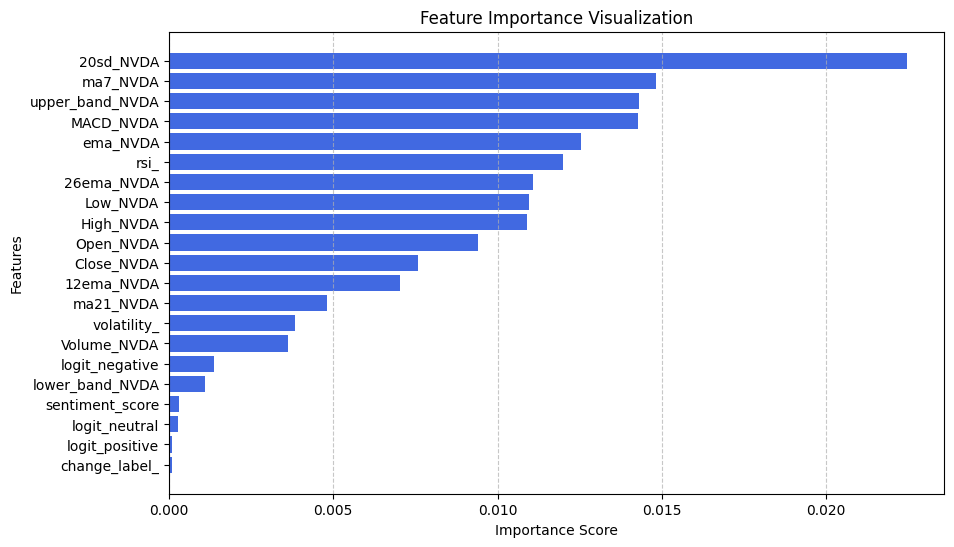

In [122]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importance data (provided)
feature_importance = [ ('20sd_NVDA', 0.02246598919706179),
    ('ma7_NVDA', 0.01483291768658588), ('upper_band_NVDA', 0.0143196281629824), ('MACD_NVDA', 0.014289224440898165),
    ('ema_NVDA', 0.012550741495423448), ('rsi_', 0.01200165616884346), ('26ema_NVDA', 0.011072750065812303),
    ('Low_NVDA', 0.010961536903799609), ('High_NVDA', 0.010893214128390241), ('Open_NVDA', 0.009417759856917281),
    ('Close_NVDA', 0.007565295280411855), ('12ema_NVDA', 0.007025929934891378), ('ma21_NVDA', 0.004814125058877231),
    ('volatility_', 0.0038297832636159396), ('Volume_NVDA', 0.0036320043705808536), ('logit_negative', 0.0013811796078875285),
    ('lower_band_NVDA', 0.0010953724126540746), ('sentiment_score', 0.0003046146852058882), ('logit_neutral', 0.00026448941107205413),
    ('logit_positive', 0.00010371363981390071), ('change_label_', 7.557136261042453e-05)
]

# Sort features by importance
feature_importance.sort(key=lambda x: x[1], reverse=True)

# Unpack the sorted data
features, importance = zip(*feature_importance)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, importance, color='royalblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Visualization')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor


# Create the model - for regression
model = RandomForestRegressor(
    n_estimators=50,
    random_state=42  # For reproducibility
)

# Train the model
model.fit(X_train_norm, y_train)

# Make predictions
y_pred = model.predict(X_test_norm)

# Evaluate the model
# For regression, you should use metrics like MSE, MAE, R²
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.6f}")

NameError: name 'X_train_norm' is not defined

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
def build_random_forest_model(X_train, y_train):
    # Random forest can automatically capture non-linear interactions
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    
    # Get feature importances
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_ranking = [(X_train.columns[i], importances[i]) for i in indices]
    
    return rf_model, feature_ranking

# Train random forest model
rf_model, feature_importance = build_random_forest_model(X_train_df, y_train)
